In [1]:
# Libraries and packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# ! pip install imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# courtesy of kaggle code
from matplotlib.gridspec import GridSpec
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
import warnings 
warnings.filterwarnings('ignore')


In [2]:
washington = pd.read_csv('./assets/washington.csv', low_memory=False)
print("Washington dataframe dimensions(shape): ", washington.shape)

Washington dataframe dimensions(shape):  (2204853, 31)


In [3]:
# currently all the departure/arrival time were set only 4 digits interger
# between 0001 to 2400. Therefore, convert it into datetime function

def time_converter(hr):
    if pd.isnull(hr):
        return np.nan
    else:
        if hr == 2400: hr = 0
        # set 4 digits 
        hr = "{0:04d}".format(int(hr)) 
        hour = datetime.time(int(hr[0:2]), int(hr[2:4]))
        return hour

# change columns name
mapping ={
    'Year': 'year',
    'Month': 'month',
    'DayofMonth': 'day',
    'DayOfWeek': 'dayofweek',
    'Carrier': 'carrier',
    'TailNum': 'tail_no',
    'FlightNum': 'flight_no',
    'Origin': 'origin',
    'Dest': 'dest',
    'CRSDepTime': 'sched_dep',
    'DepTime': 'dep_time',
    'DepDelay': 'dep_delay',
    'TaxiOut': 'taxi_out',
    'WheelsOff': 'wheels_off',
    'WheelsOn': 'wheels_on',
    'TaxiIn': 'taxi_in',
    'CRSArrTime': 'sched_arr',
    'ArrTime': 'arr_time',
    'ArrDelay': 'arr_delay',
    'Cancelled': 'cancelled',
    'CancellationCode': 'cancel_code',
    'Diverted': 'diverted',
    'CRSElapsedTime': 'sched_elapsed',
    'ActualElapsedTime': 'elapsed_time',
    'AirTime': 'air_time',
    'Distance': 'distance',
    'CarrierDelay': 'carrier_delay',
    'WeatherDelay': 'weather_delay',
    'NASDelay': 'system_delay',
    'SecurityDelay': 'security_delay',
    'LateAircraftDelay': 'late_aircraft_delay'
}

day_map = {
    '1': 'Mon', '2': 'Tue', '3': 'Wed', '4': 'Thu',
    '5': 'Fri', '6': 'Sat', '7': 'Sun'
}

def preprocessing(df):
    # easier to work with lowercase columns
    df = df.rename(columns=mapping)
    
    # convert it to datetime
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    
    # apply time converter to dep/arr time
    times = ['sched_dep', 'dep_time', 'sched_arr', 'arr_time']
    for x in times:
        df[x] = df[x].apply(time_converter)
    
    # apply dayofweek
    df['dayofweek'] = df['dayofweek'].astype(str).map(day_map)
    
    # fill tail_no
    df['tail_no'] = df['tail_no'].fillna('na')
    return df

In [4]:
# counting null values in dataframe

def isnull_counter(df):
    foobar = df.isnull().sum(axis=0).reset_index()
    foobar.columns = ['variable', 'missing values']
    foobar['filling factor (%)']=(df.shape[0]-foobar['missing values'])/df.shape[0]*100
    return foobar.sort_values('filling factor (%)').reset_index(drop = True).round(4)

# counting categorical columns' value counts
def value_counter(df):
    foobar = df.value_counts().reset_index()
    foobar.columns = ['value', 'counts']
    foobar['(%)'] = df.value_counts(normalize=True).reset_index(drop=True).round(4)
    return foobar

In [5]:
isnull_counter(washington)

,variable,missing values,filling factor (%)
0,CancellationCode,2161504,1.9661
1,LateAircraftDelay,1784905,19.0465
2,NASDelay,1784905,19.0465
3,WeatherDelay,1784905,19.0465
4,CarrierDelay,1784905,19.0465
5,SecurityDelay,1784905,19.0465
6,AirTime,48161,97.8157
7,ActualElapsedTime,48161,97.8157
8,ArrDelay,48161,97.8157
9,ArrTime,44131,97.9985


In [6]:
washington = preprocessing(washington)

In [7]:
washington.shape

(2204853, 32)

### Drop cancelled flights

In [8]:
# Dropped cancelled flights
df=washington[washington.cancelled == 0]
print("Original dimension: ", washington.shape, "\nNew dimension     : ", df.shape)

Original dimension:  (2204853, 32) 
New dimension     :  (2161504, 32)


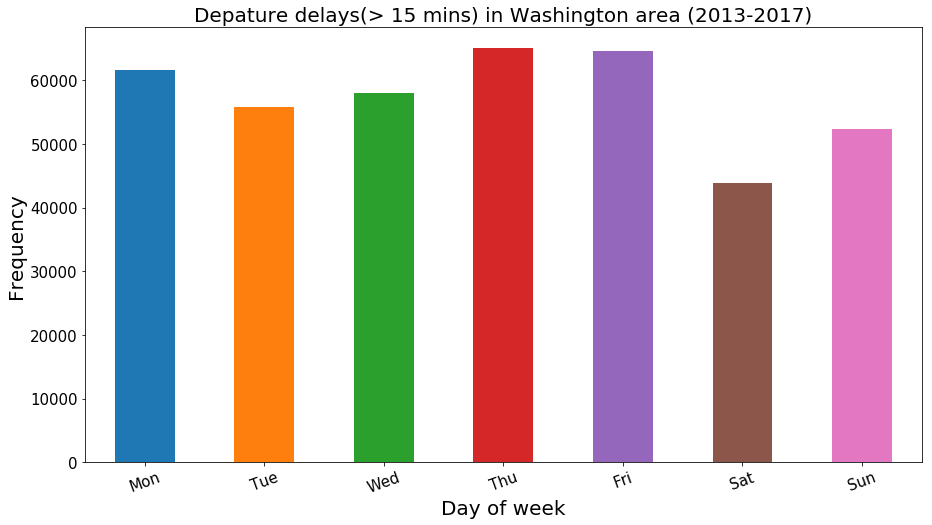

In [9]:
# set days of week order as list
daysofweek=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# plot
df[df.dep_delay > 15]['dayofweek'].value_counts()[daysofweek].plot(kind='bar', figsize=(15,8))
plt.title("Depature delays(> 15 mins) in Washington area (2013-2017)", size=20)
plt.xticks(size=15, rotation=20)
plt.yticks(size=15)
plt.xlabel("Day of week", size=20)
plt.ylabel("Frequency", size=20);

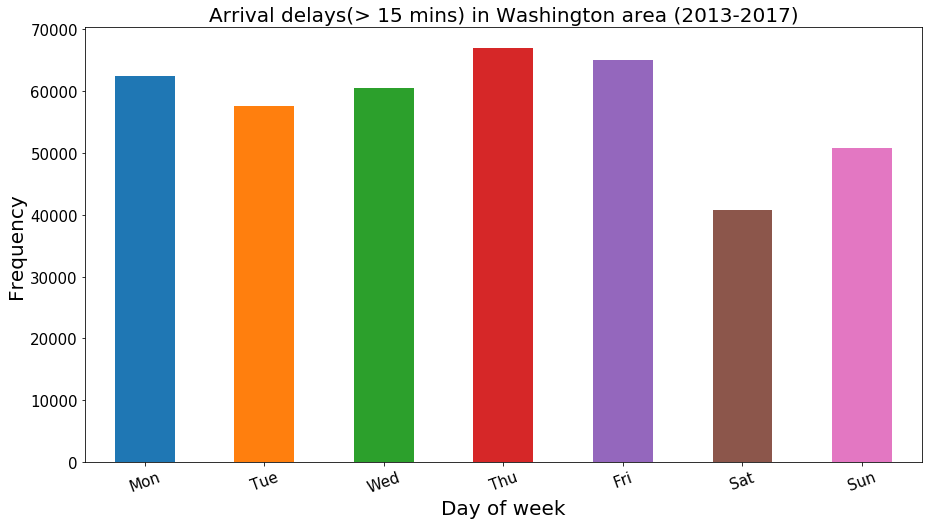

In [10]:
df[df.arr_delay > 15]['dayofweek'].value_counts()[daysofweek].plot(kind='bar', figsize=(15,8))
plt.title("Arrival delays(> 15 mins) in Washington area (2013-2017)", size=20)
plt.xticks(size=15, rotation=20)
plt.yticks(size=15)
plt.xlabel("Day of week", size=20)
plt.ylabel("Frequency", size=20);

### Bring airline name

In [11]:
df.carrier.unique()

array(['DL', 'B6', 'EV', 'F9', 'FL', 'MQ', '9E', 'AA', 'AS', 'US', 'VX',
       'UA', 'WN', 'YV', 'OO', 'NK'], dtype=object)

In [12]:
airlines_names=pd.read_csv('./assets/kaggle/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [13]:
airlines_names=airlines_names.append(pd.DataFrame([['FL', 'AirTran'], ['9E', 'Endeavor'], ['YV', 'Mesa']], columns=['IATA_CODE', 'AIRLINE']), ignore_index=True)
carrier_code=airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [14]:
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


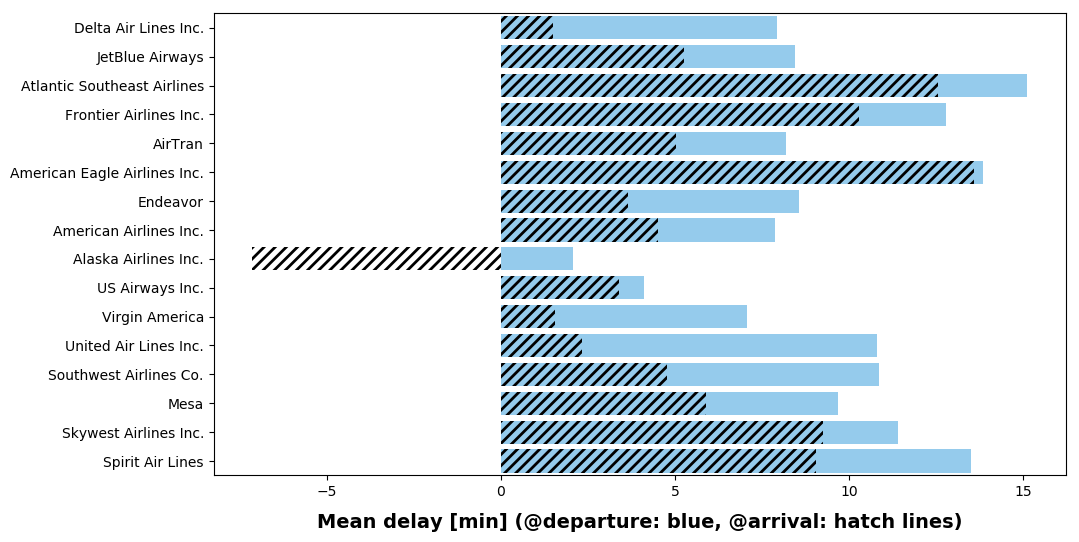

In [15]:
# Courtesy of Fabien Daniel of Kaggle


mpl.rc('patch', edgecolor='dimgray', linewidth=1)

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="dep_delay", y="carrier", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="arr_delay", y="carrier", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [carrier_code[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

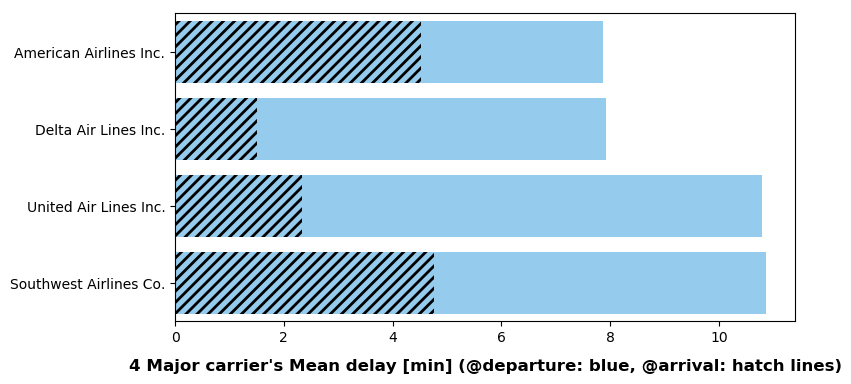

In [16]:
# Courtesy of Fabien Daniel of Kaggle

mpl.rc('patch', edgecolor='dimgray', linewidth=1)

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(8,4))

# Subset 4 major airlines
ax = sns.barplot(x="dep_delay", y="carrier", data=df, order=['AA','DL', 'UA', 'WN'], color="lightskyblue", ci=None)
ax = sns.barplot(x="arr_delay", y="carrier", data=df, order=['AA','DL', 'UA', 'WN'], color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [carrier_code[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel("4 Major carrier's Mean delay [min] (@departure: blue, @arrival: hatch lines)",
           fontsize=12, weight = 'bold', labelpad=10);

In [17]:
df.origin.value_counts()[:3]

BWI    475045
DCA    370043
IAD    235386
Name: origin, dtype: int64

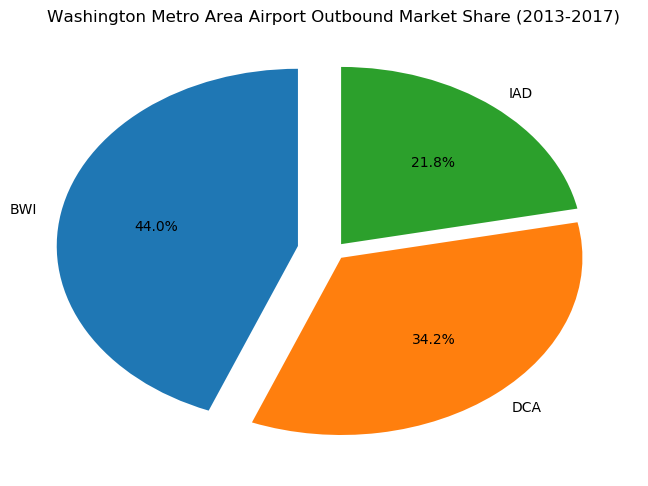

In [18]:
# inspired and courtesy of Chris Albon- https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/

plt.pie(
    df.origin.value_counts()[:3],
    labels=df.origin.value_counts()[:3].index,
    explode=(0.15, 0.05, 0.05),
    startangle=90,
    autopct='%1.1f%%')

plt.tight_layout()
plt.title("Washington Metro Area Airport Outbound Market Share (2013-2017)")
plt.show()

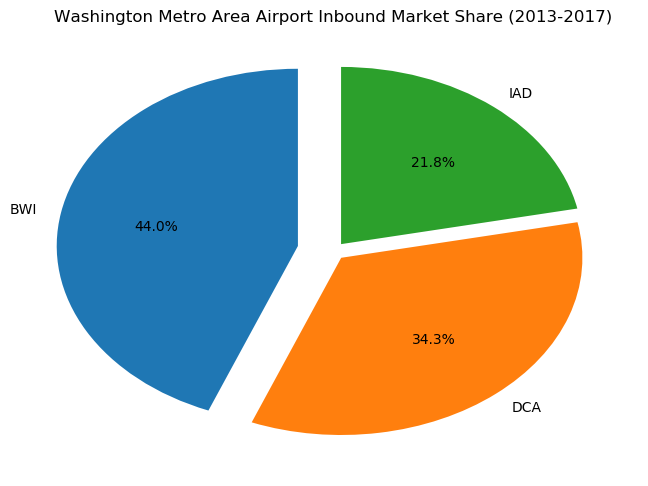

In [19]:
# inspired and courtesy of Chris Albon- https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/

plt.pie(
    df.dest.value_counts()[:3],
    labels=df.origin.value_counts()[:3].index,
    explode=(0.15, 0.05, 0.05),
    startangle=90,
    autopct='%1.1f%%')

plt.tight_layout()
plt.title("Washington Metro Area Airport Inbound Market Share (2013-2017)")
plt.show()

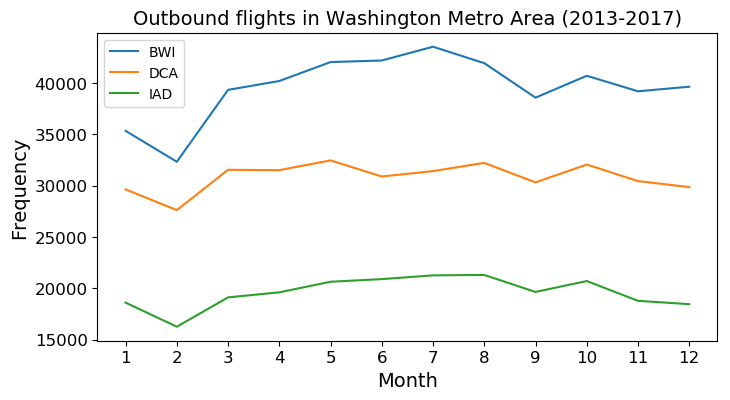

In [20]:
fig = plt.figure(1, figsize=(8,4))
df[df.origin == 'BWI']['month'].value_counts().sort_index().plot(kind='line', color='#1E77B4')
df[df.origin == 'DCA']['month'].value_counts().sort_index().plot(kind='line', color='#FF7F0F')
df[df.origin == 'IAD']['month'].value_counts().sort_index().plot(kind='line', color='#2DA02B')
plt.title("Outbound flights in Washington Metro Area (2013-2017)", size=14)
plt.xticks(range(1,13), size=12)
plt.yticks(size=12)
plt.xlabel("Month", size=14)
plt.ylabel("Frequency", size=14)
plt.legend(['BWI', 'DCA', 'IAD']);

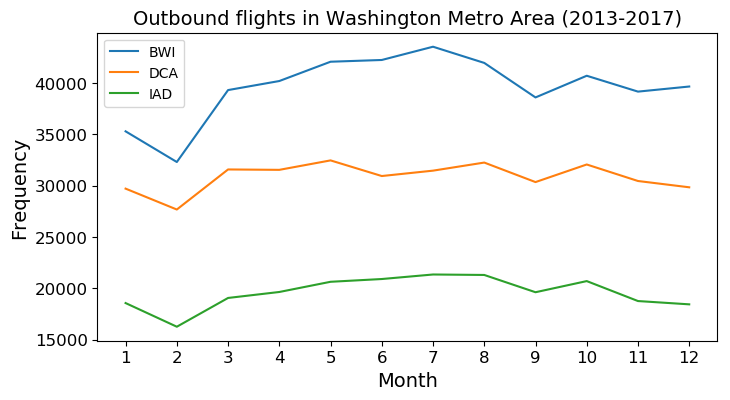

In [21]:
fig = plt.figure(1, figsize=(8,4))
df[df.dest == 'BWI']['month'].value_counts().sort_index().plot(kind='line', color='#1E77B4')
df[df.dest == 'DCA']['month'].value_counts().sort_index().plot(kind='line', color='#FF7F0F')
df[df.dest == 'IAD']['month'].value_counts().sort_index().plot(kind='line', color='#2DA02B')
plt.title("Outbound flights in Washington Metro Area (2013-2017)", size=14)
plt.xticks(range(1,13), size=12)
plt.yticks(size=12)
plt.xlabel("Month", size=14)
plt.ylabel("Frequency", size=14)
plt.legend(['BWI', 'DCA', 'IAD']);

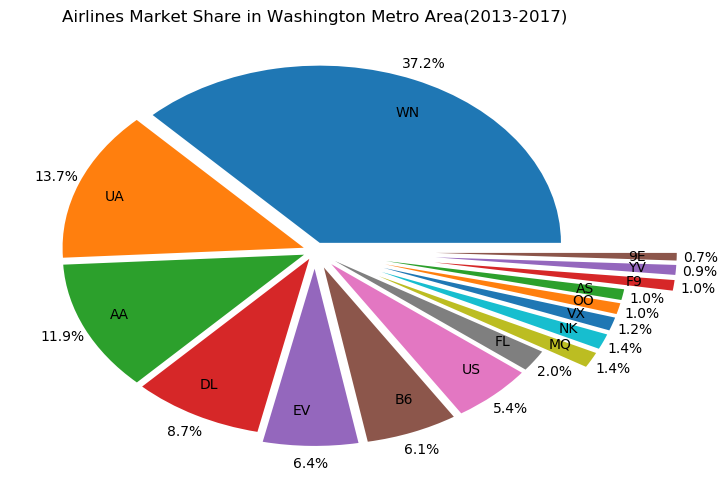

In [22]:
# inspired and courtesy of Chris Albon- https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/

plt.pie(
    df.carrier.value_counts(),
    labels=df.carrier.value_counts().index,
    explode=(0.05, 0.05, 0.05, 0.05, 0.1,0.1,0.1,0.1,0.3,0.3,0.3,0.3,0.3,0.5,0.5,0.5),
#     startangle=30,
    autopct='%1.1f%%',
    pctdistance=1.1, labeldistance=0.8)

plt.tight_layout()
plt.title("Airlines Market Share in Washington Metro Area(2013-2017)")
plt.show();

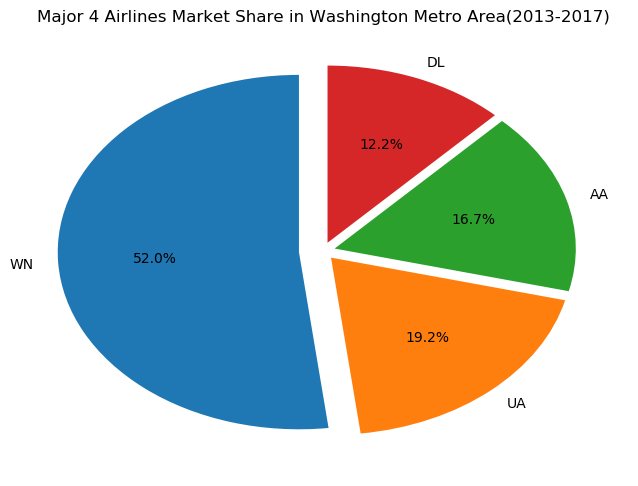

In [23]:
# inspired and courtesy of Chris Albon- https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/

plt.pie(
    df.carrier.value_counts()[:4],
    labels=df.carrier.value_counts()[:4].index,
    explode=(0.1, 0.05, 0.05, 0.05),
    startangle=90,
    autopct='%1.1f%%')

plt.tight_layout()
plt.title("Major 4 Airlines Market Share in Washington Metro Area(2013-2017)")
plt.show();

In [24]:
value_counter(df.carrier)

,value,counts,(%)
0,WN,803586,0.3718
1,UA,296516,0.1372
2,AA,257611,0.1192
3,DL,188839,0.0874
4,EV,137577,0.0636
5,B6,132779,0.0614
6,US,117654,0.0544
7,FL,42163,0.0195
8,MQ,30525,0.0141
9,NK,30193,0.0140


### drop columns and realign it

In [25]:
variables_to_remove = ['taxi_out', 'taxi_in', 'wheels_on', 'wheels_off', 'system_delay',
                       'security_delay', 'carrier_delay', 'late_aircraft_delay',
                       'weather_delay', 'diverted', 'cancelled', 'cancel_code', 'air_time',
                       'year', 'month', 'day']

df = df.drop(variables_to_remove, axis=1)

df = df[['date', 'dayofweek', 'carrier', 'flight_no', 'origin', 'dest',
         'sched_dep', 'dep_time', 'dep_delay', 'sched_arr', 'arr_time',
         'arr_delay', 'sched_elapsed', 'elapsed_time', 'distance', 'tail_no']]

df.head()

,date,dayofweek,carrier,flight_no,origin,dest,sched_dep,dep_time,dep_delay,sched_arr,arr_time,arr_delay,sched_elapsed,elapsed_time,distance,tail_no
0,2013-09-17,Tue,DL,2125,BWI,ATL,12:40:00,12:37:00,-3.0,14:33:00,14:42:00,9.0,113.0,125.0,577.0,N948DL
1,2013-09-17,Tue,DL,2137,BWI,DTW,07:40:00,07:38:00,-2.0,09:13:00,09:04:00,-9.0,93.0,86.0,409.0,N958DL
2,2013-09-17,Tue,DL,2145,DCA,DTW,19:00:00,19:32:00,32.0,20:35:00,21:01:00,26.0,95.0,89.0,405.0,N913DE
3,2013-09-17,Tue,DL,2163,DCA,MSP,06:30:00,06:49:00,19.0,08:04:00,08:33:00,29.0,154.0,164.0,931.0,N938DN
4,2013-09-17,Tue,DL,2239,DCA,ATL,17:00:00,17:15:00,15.0,18:50:00,19:24:00,34.0,110.0,129.0,547.0,N953DN


In [26]:
isnull_counter(df)

,variable,missing values,filling factor (%)
0,arr_delay,4812,99.7774
1,elapsed_time,4812,99.7774
2,arr_time,782,99.9638
3,date,0,100.0000
4,dayofweek,0,100.0000
5,carrier,0,100.0000
6,flight_no,0,100.0000
7,origin,0,100.0000
8,dest,0,100.0000
9,sched_dep,0,100.0000


The variables filling factor is quite great (>99%). I will remove the entries that contains missing values. 

In [27]:
df.dropna(inplace=True)

In [28]:
print("Original dimension: ", washington.shape, "\nNew dimension     : ", df.shape)

Original dimension:  (2204853, 32) 
New dimension     :  (2156692, 16)


In [29]:
df.tail_no.nunique()

5558

### Let's merge aircraft dataset

In [30]:
aircrafts=pd.read_csv('./assets/aircrafts.csv', low_memory=False)
aircrafts.head(5)

,age(year),aircraft,shipped,tailno,type_code
0,NaN,NaN,NaN,N028AA,NaN
1,11 years,Bombardier CRJ-900LR,AGE (Aug 2006),N806SK,CRJ9
2,13 years,Boeing 737-8FH,AGE (Feb 2005),N549AS,B738
3,7 years,Boeing 737-890,AGE (Jan 2011),N534AS,B738
4,18 years,Airbus A319-114,AGE (Feb 2000),N314NB,A319


In [31]:
aircrafts.shape

(6459, 5)

In [32]:
isnull_counter(aircrafts)

,variable,missing values,filling factor (%)
0,shipped,1238,80.8329
1,age(year),592,90.8345
2,aircraft,589,90.8809
3,type_code,589,90.8809
4,tailno,0,100.0000


In [33]:
aircrafts.shape

(6459, 5)

### Let's use tailno, type_code, manufacturer.

In [34]:
get_manufacturer = lambda x: x.split(' ')[0]
aircrafts['builder']=aircrafts.aircraft.astype(str).apply(get_manufacturer)
aircrafts['builder']=aircrafts['builder'].replace("-", "Unknown").replace("nan", "Unknown")
aircrafts['builder'].value_counts()

Boeing            2351
Unknown           1414
Airbus            1138
Bombardier         681
Embraer            478
McDonnell          224
Cessna              48
Beech               26
Piper               15
Gulfstream          11
Cirrus              10
Van's                7
Air                  6
Bell                 6
Dassault             5
Socata               5
Short                4
Beech A36            3
Learjet              3
Mcdonnell            3
DJI                  3
Mooney               2
Diamond              2
Robinson             2
Pilatus              2
AgustaWestland       1
Phoenix              1
Hawker               1
Partenavia           1
Lockwood             1
Mitsubishi           1
Quest                1
Aero                 1
Canadair             1
Sikorsky             1
Name: builder, dtype: int64

In [35]:
aircrafts['builder'].value_counts().index[:5]

Index(['Boeing', 'Unknown', 'Airbus', 'Bombardier', 'Embraer'], dtype='object')

In [36]:
aircrafts['builder']=[build if build in aircrafts['builder'].value_counts().index[:5] else "Other" for build in aircrafts['builder']]
aircrafts['builder'].value_counts()

Boeing        2351
Unknown       1414
Airbus        1138
Bombardier     681
Embraer        478
Other          397
Name: builder, dtype: int64

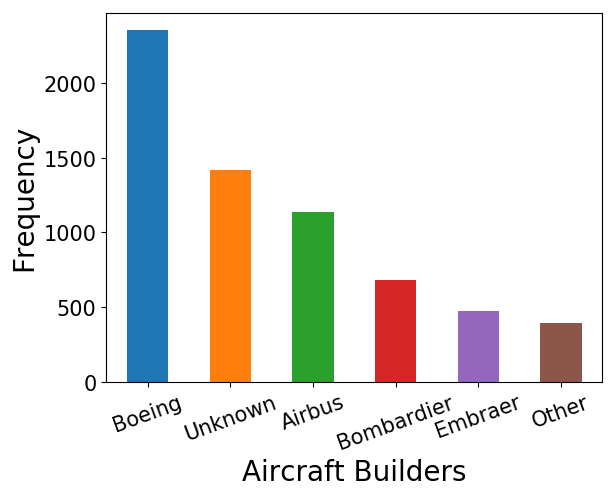

In [37]:
aircrafts['builder'].value_counts().plot(kind='bar')
# plt.title("Depature delays(> 15 mins) in Washington area (2013-2017)", size=20)
plt.xticks(size=15, rotation=20)
plt.yticks(size=15)
plt.xlabel("Aircraft Builders", size=20)
plt.ylabel("Frequency", size=20);

##### drop aircraft, shipped, age for the later phase

In [38]:
aircrafts.drop(['aircraft', 'shipped', 'age(year)'], axis=1, inplace=True)
aircrafts.type_code.fillna("Unknown", inplace=True)

In [39]:
isnull_counter(aircrafts)

,variable,missing values,filling factor (%)
0,tailno,0,100.0
1,type_code,0,100.0
2,builder,0,100.0


##### Later! Create binary dummy variables by 6 different categories in flight age: Unknown, brand_new(< 1yr), new(< 10yrs), old(< 20yrs), older(< 40yrs), oldest(> 40yrs) 

Let's leave it here

### Let's merge aircraft and washington data

In [40]:
print("Washington dataframe dimension: ", df.shape)
print("aircraft dataframe dimension  : ", aircrafts.shape)

Washington dataframe dimension:  (2156692, 16)
aircraft dataframe dimension  :  (6459, 3)


In [41]:
df = pd.merge(df, aircrafts.drop_duplicates(), how='left', left_on="tail_no", right_on="tailno")
df.shape

(2156692, 19)

### Save it for the future usage

In [42]:
df.to_pickle('./assets/capstoneday_model.pkl')

In [43]:
df.head()

,date,dayofweek,carrier,flight_no,origin,dest,sched_dep,dep_time,dep_delay,sched_arr,arr_time,arr_delay,sched_elapsed,elapsed_time,distance,tail_no,tailno,type_code,builder
0,2013-09-17,Tue,DL,2125,BWI,ATL,12:40:00,12:37:00,-3.0,14:33:00,14:42:00,9.0,113.0,125.0,577.0,N948DL,N948DL,MD88,Other
1,2013-09-17,Tue,DL,2137,BWI,DTW,07:40:00,07:38:00,-2.0,09:13:00,09:04:00,-9.0,93.0,86.0,409.0,N958DL,N958DL,MD88,Other
2,2013-09-17,Tue,DL,2145,DCA,DTW,19:00:00,19:32:00,32.0,20:35:00,21:01:00,26.0,95.0,89.0,405.0,N913DE,NaN,NaN,NaN
3,2013-09-17,Tue,DL,2163,DCA,MSP,06:30:00,06:49:00,19.0,08:04:00,08:33:00,29.0,154.0,164.0,931.0,N938DN,N938DN,MD90,Other
4,2013-09-17,Tue,DL,2239,DCA,ATL,17:00:00,17:15:00,15.0,18:50:00,19:24:00,34.0,110.0,129.0,547.0,N953DN,N953DN,MD90,Other


### Check values

In [44]:
# courtesy by kaggle

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

# separately by each dataframe
stats = df['dep_delay'].groupby(df['carrier']).apply(get_stats).unstack()
stats = stats.sort_values('count')
stats

# get groupby stats on delays of each airlines
# count_delays(holidays)

,count,max,mean,min
carrier,,,,
9E,14816.0,513.0,8.560813,-23.0
YV,19391.0,438.0,9.653499,-31.0
F9,20676.0,699.0,12.781969,-63.0
AS,21219.0,715.0,2.053160,-25.0
OO,21598.0,1398.0,11.339430,-21.0
VX,26101.0,705.0,7.053446,-24.0
NK,30160.0,1551.0,13.485875,-50.0
MQ,30472.0,1172.0,13.805756,-46.0
FL,42102.0,989.0,8.178091,-23.0


In [45]:
# separately by each dataframe
df['dep_delay'].groupby(df['type_code']).apply(get_stats).unstack().sort_values('count')


,count,max,mean,min
type_code,,,,
DA40,2.0,23.0,10.000000,-3.0
B744,4.0,40.0,11.250000,-2.0
PA34,6.0,0.0,-4.166667,-8.0
B77W,6.0,45.0,16.833333,1.0
E135,6.0,216.0,65.500000,-13.0
B762,12.0,225.0,35.083333,-2.0
LJ60,12.0,75.0,7.166667,-8.0
PA27,16.0,249.0,14.062500,-9.0
GLF2,18.0,42.0,11.000000,-7.0


### Subset it for outbound / inbound flights for plot

In [46]:
outbound = df[(df['origin'] == 'DCA') | (df['origin'] == 'IAD') | (df['origin'] == 'BWI')]
inbound = df[(df['dest'] == 'DCA') | (df['dest'] == 'IAD') | (df['dest'] == 'BWI')]
print("Outbound: ", outbound.shape, "\nInbound : ", inbound.shape)

Outbound:  (1078157, 19) 
Inbound :  (1078535, 19)


### Outbound / Inbound delay graphs
- Green graph: Mean delay in minutes
- Blue graph: Delay (> 15 mins) rate(%)

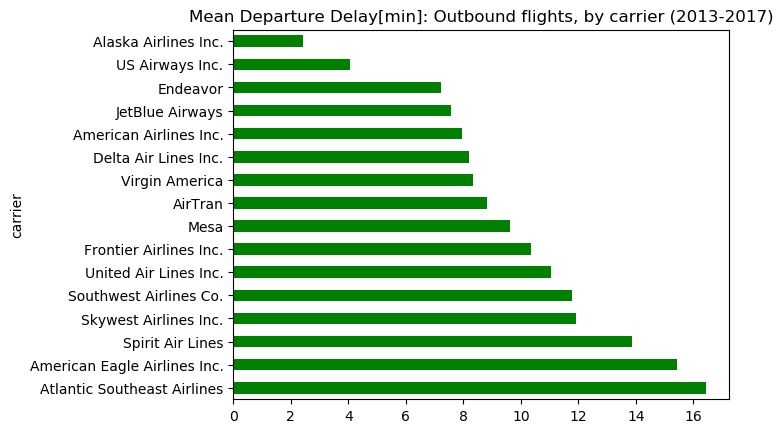

In [47]:
outbound['foobar'] = outbound['dep_delay']
ax=outbound.groupby('carrier')['foobar'].mean().sort_values(ascending=False).plot(kind='barh', color='g')
label = [carrier_code[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels=label)
ax.set_title("Mean Departure Delay[min]: Outbound flights, by carrier (2013-2017)");

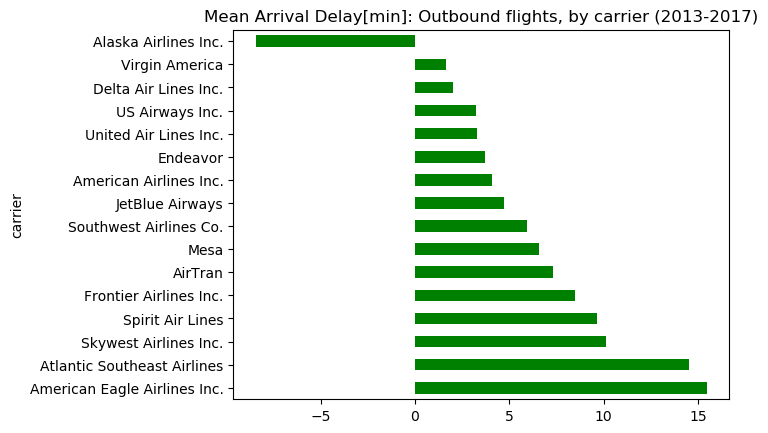

In [48]:
outbound['foobar'] = outbound['arr_delay']
ax=outbound.groupby('carrier')['foobar'].mean().sort_values(ascending=False).plot(kind='barh', color='g')
outbound.drop('foobar', axis=1, inplace=True)
label = [carrier_code[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels=label)
ax.set_title("Mean Arrival Delay[min]: Outbound flights, by carrier (2013-2017)");

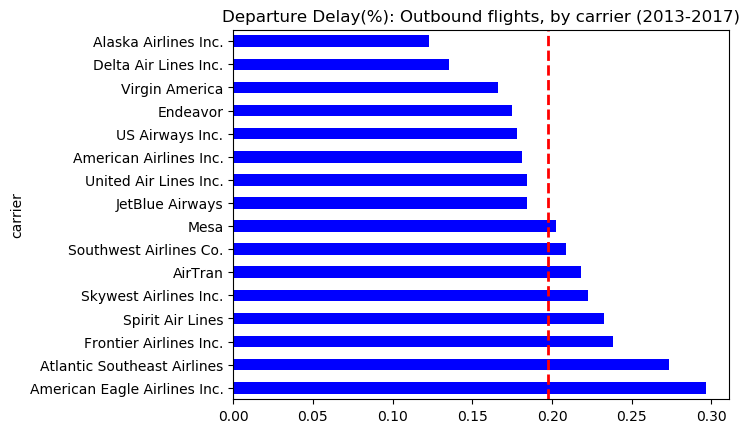

In [49]:
outbound['foobar'] = outbound['arr_delay'] > 15

plt.axvline(outbound['foobar'].mean(), color='r', linestyle='dashed', linewidth=2)
ax=outbound.groupby('carrier')['foobar'].mean().sort_values(ascending=False).plot(kind='barh', color='b')
outbound.drop('foobar', axis=1, inplace=True)
label = [carrier_code[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels=label)
ax.set_title("Departure Delay(%): Outbound flights, by carrier (2013-2017)");

In [50]:
outbound['foobar'] = outbound['arr_delay'] > 15
print(outbound.groupby('carrier')['foobar'].mean().sort_values(ascending=False))
outbound.drop('foobar', axis=1, inplace=True)

carrier
MQ    0.296335
EV    0.273719
F9    0.238049
NK    0.232544
OO    0.222554
FL    0.217984
WN    0.209060
YV    0.202366
B6    0.184637
UA    0.184331
AA    0.181100
US    0.177941
9E    0.174631
VX    0.166130
DL    0.135621
AS    0.123007
Name: foobar, dtype: float64


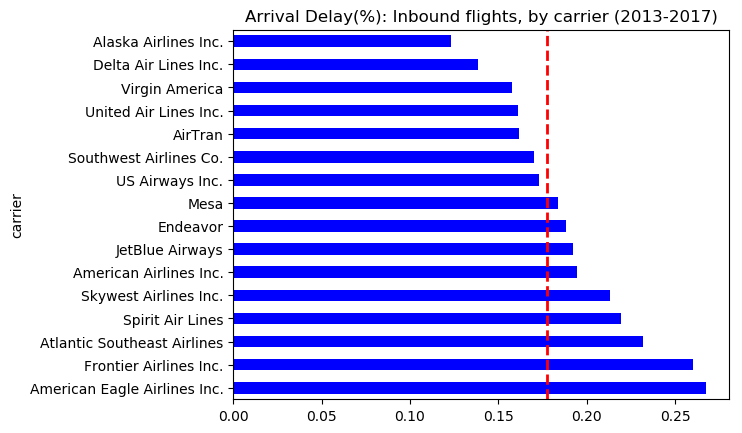

In [51]:
inbound['foobar'] = inbound['arr_delay'] > 15
plt.axvline(inbound['foobar'].mean(), color='r', linestyle='dashed', linewidth=2)
ax=inbound.groupby('carrier')['foobar'].mean().sort_values(ascending=False).plot(kind='barh', color='b')
inbound.drop('foobar', axis=1, inplace=True)
label = [carrier_code[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels=label)
ax.set_title("Arrival Delay(%): Inbound flights, by carrier (2013-2017)");

In [52]:
inbound['foobar'] = inbound['arr_delay'] > 15
print(inbound.groupby('carrier')['foobar'].mean().sort_values(ascending=False))
inbound.drop('foobar', axis=1, inplace=True)

carrier
MQ    0.267204
F9    0.260104
EV    0.232099
NK    0.219113
OO    0.213217
AA    0.194621
B6    0.192337
9E    0.188451
YV    0.183849
US    0.172970
WN    0.170326
FL    0.161805
UA    0.161323
VX    0.157536
DL    0.138505
AS    0.123470
Name: foobar, dtype: float64


### Get cyclical sin/cos time

In [46]:
# get minutes function
get_minutes = lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1])
minutes_in_day = 24 * 60

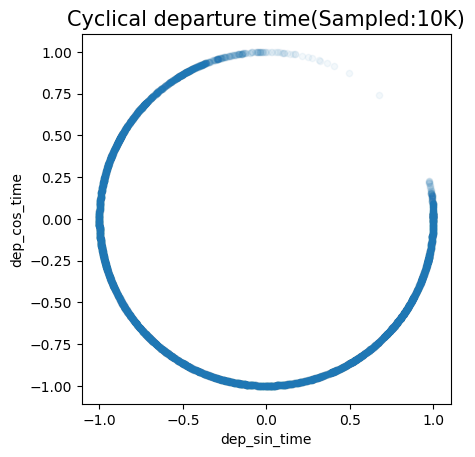

In [47]:
dep_minutes=df.dep_time.astype(str).apply(get_minutes)

# https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

df['dep_sin_time'] = np.sin(2*np.pi*dep_minutes/minutes_in_day)
df['dep_cos_time'] = np.cos(2*np.pi*dep_minutes/minutes_in_day)

df.sample(10000).plot.scatter('dep_sin_time','dep_cos_time', alpha=.05).set_aspect('equal')
plt.title("Cyclical departure time(Sampled:10K)", size=15);

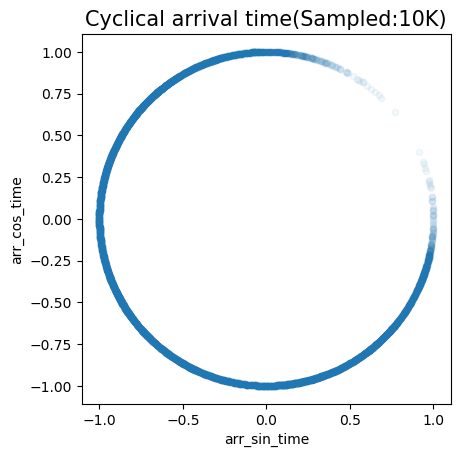

In [48]:
arr_minutes=df.arr_time.astype(str).apply(get_minutes)

df['arr_sin_time'] = np.sin(2*np.pi*arr_minutes/minutes_in_day)
df['arr_cos_time'] = np.cos(2*np.pi*arr_minutes/minutes_in_day)

df.sample(10000).plot.scatter('arr_sin_time','arr_cos_time', alpha=.05).set_aspect('equal')
plt.title("Cyclical arrival time(Sampled:10K)", size=15);

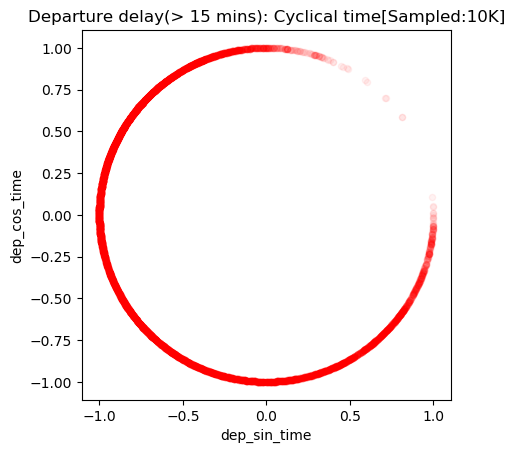

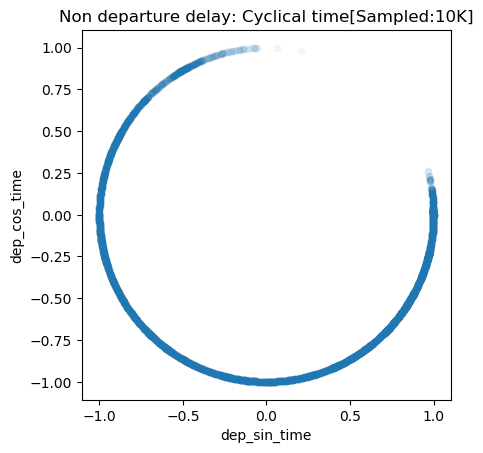

In [49]:
df[df['dep_delay'] > 15].sample(10000).plot.scatter('dep_sin_time','dep_cos_time', color='r', alpha=.05, title="Departure delay(> 15 mins): Cyclical time[Sampled:10K]").set_aspect('equal')
df[df['dep_delay'] <= 0].sample(10000).plot.scatter('dep_sin_time','dep_cos_time', alpha=.05, title="Non departure delay: Cyclical time[Sampled:10K]").set_aspect('equal');

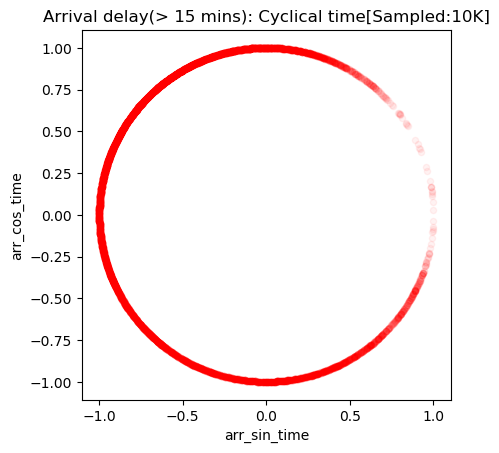

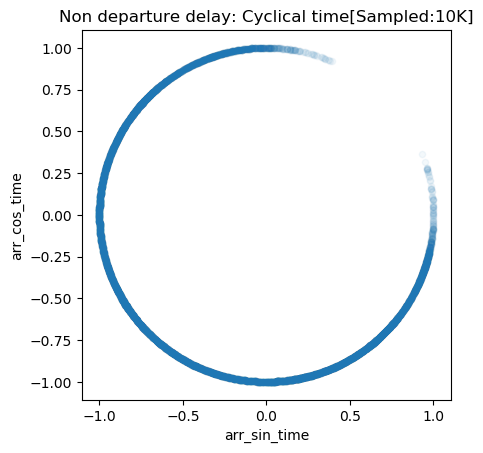

In [50]:
df[df['arr_delay'] > 15].sample(10000).plot.scatter('arr_sin_time','arr_cos_time', color='r', alpha=.05, title="Arrival delay(> 15 mins): Cyclical time[Sampled:10K]").set_aspect('equal')
df[df['arr_delay'] <= 0].sample(10000).plot.scatter('arr_sin_time','arr_cos_time', alpha=.05, title="Non departure delay: Cyclical time[Sampled:10K]").set_aspect('equal');

### back to DF

In [51]:
df.head()

,date,dayofweek,carrier,flight_no,origin,dest,sched_dep,dep_time,dep_delay,sched_arr,...,elapsed_time,distance,tail_no,tailno,type_code,builder,dep_sin_time,dep_cos_time,arr_sin_time,arr_cos_time
0,2013-09-17,Tue,DL,2125,BWI,ATL,12:40:00,12:37:00,-3.0,14:33:00,...,125.0,577.0,N948DL,N948DL,MD88,Other,-0.160743,-0.986996,-0.649448,-0.760406
1,2013-09-17,Tue,DL,2137,BWI,DTW,07:40:00,07:38:00,-2.0,09:13:00,...,86.0,409.0,N958DL,N958DL,MD88,Other,0.909961,-0.414693,0.694658,-0.719340
2,2013-09-17,Tue,DL,2145,DCA,DTW,19:00:00,19:32:00,32.0,20:35:00,...,89.0,405.0,N913DE,NaN,NaN,NaN,-0.920505,0.390731,-0.704015,0.710185
3,2013-09-17,Tue,DL,2163,DCA,MSP,06:30:00,06:49:00,19.0,08:04:00,...,164.0,931.0,N938DN,N938DN,MD90,Other,0.977231,-0.212178,0.785317,-0.619094
4,2013-09-17,Tue,DL,2239,DCA,ATL,17:00:00,17:15:00,15.0,18:50:00,...,129.0,547.0,N953DN,N953DN,MD90,Other,-0.980785,-0.195090,-0.933580,0.358368


In [52]:
isnull_counter(df)

,variable,missing values,filling factor (%)
0,builder,216610,89.9564
1,type_code,216610,89.9564
2,tailno,216610,89.9564
3,date,0,100.0000
4,dep_cos_time,0,100.0000
5,dep_sin_time,0,100.0000
6,tail_no,0,100.0000
7,distance,0,100.0000
8,elapsed_time,0,100.0000
9,sched_elapsed,0,100.0000


##### filling factor is in  (> 89%) which is not bad, but no sure to drop it. Therefore try build two models. 

In [53]:
# drop null in type_code, tailno, builder. almost 10% of data.
df2 = df.dropna()

In [54]:
# assign "unknown" to null values
df.type_code.fillna("Unknown", inplace=True)
df.type_code=df.type_code.replace("-", "Unknown")
topten = df.type_code.value_counts()[:10].index
df.type_code=df.type_code.map(lambda x: x if x in topten else 'Other')
df.builder.fillna("Unknown", inplace=True)

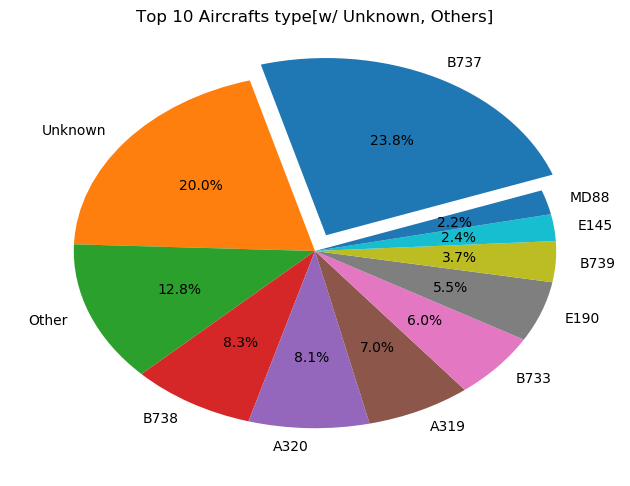

In [55]:
# inspired and courtesy of Chris Albon- https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/

plt.pie(
    df.type_code.value_counts(),
    labels=df.type_code.value_counts().index,
    explode=(0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    startangle=20,
    autopct='%1.1f%%')

plt.tight_layout()
plt.title("Top 10 Aircrafts type[w/ Unknown, Others]")
plt.show()

In [56]:
value_counter(df.type_code)

,value,counts,(%)
0,B737,513302,0.2380
1,Unknown,432238,0.2004
2,Other,276514,0.1282
3,B738,179728,0.0833
4,A320,174269,0.0808
5,A319,151638,0.0703
6,B733,129378,0.0600
7,E190,118909,0.0551
8,B739,80215,0.0372
9,E145,52537,0.0244


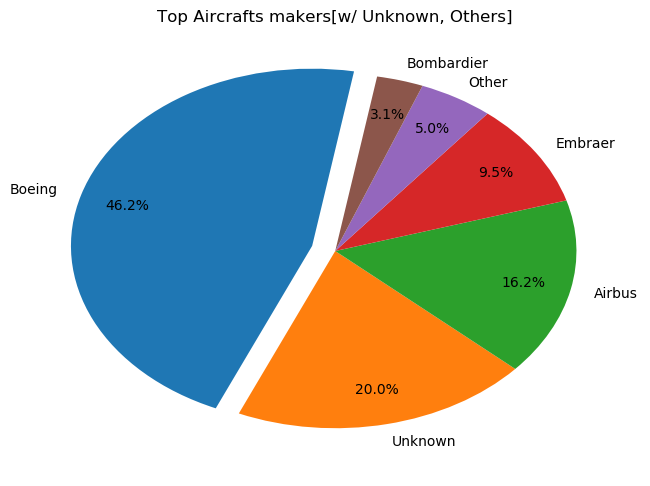

In [57]:
# inspired and courtesy of Chris Albon- https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/

plt.pie(
    df.builder.value_counts(),
    labels=df.builder.value_counts().index,
    explode=(0.1, 0, 0, 0, 0, 0),
    startangle=80,
    autopct='%1.1f%%', pctdistance=0.8)

plt.tight_layout()
plt.title("Top Aircrafts makers[w/ Unknown, Others]")
plt.show()

In [58]:
value_counter(df.builder)[:10]

,value,counts,(%)
0,Boeing,997130,0.4623
1,Unknown,430296,0.1995
2,Airbus,349405,0.1620
3,Embraer,205180,0.0951
4,Other,107481,0.0498
5,Bombardier,67200,0.0312


In [59]:
isnull_counter(df)

,variable,missing values,filling factor (%)
0,tailno,216610,89.9564
1,date,0,100.0000
2,dep_cos_time,0,100.0000
3,dep_sin_time,0,100.0000
4,builder,0,100.0000
5,type_code,0,100.0000
6,tail_no,0,100.0000
7,distance,0,100.0000
8,elapsed_time,0,100.0000
9,sched_elapsed,0,100.0000


# Modeling

### Check the baseline

In [60]:
def map_labels(delays):
    if delays > 15:
        return 1
    else:
        return 0

In [61]:
df['delayed'] = ((df['dep_delay'].map(map_labels) + df['arr_delay'].map(map_labels)) != 0).astype(int)
df['delayed'].value_counts(normalize=True)

0    0.772873
1    0.227127
Name: delayed, dtype: float64

In [69]:
df2['delayed'] = ((df2['dep_delay'].map(map_labels) + df2['arr_delay'].map(map_labels)) != 0).astype(int)
df2['delayed'].value_counts(normalize=True)

0    0.772469
1    0.227531
Name: delayed, dtype: float64

There is not much meaningful baseline differency in two dfs.

##### Dummify and drop numerical cols

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2156692 entries, 0 to 2156691
Data columns (total 24 columns):
date             datetime64[ns]
dayofweek        object
carrier          object
flight_no        int64
origin           object
dest             object
sched_dep        object
dep_time         object
dep_delay        float64
sched_arr        object
arr_time         object
arr_delay        float64
sched_elapsed    float64
elapsed_time     float64
distance         float64
tail_no          object
tailno           object
type_code        object
builder          object
dep_sin_time     float64
dep_cos_time     float64
arr_sin_time     float64
arr_cos_time     float64
delayed          int64
dtypes: datetime64[ns](1), float64(9), int64(2), object(12)
memory usage: 411.4+ MB


In [63]:
df1 = df.drop(['date', 'flight_no', 'sched_dep', 'dep_time', 'dep_delay', 'sched_arr', 
               'arr_time', 'arr_delay', 'sched_elapsed', 'elapsed_time', 'tail_no',
               'tailno'], axis=1)
df1= pd.get_dummies(df1, columns=['dayofweek', 'carrier', 'origin', 
                                  'dest', 'type_code', 'builder'])

##### Set Target, Features and Train/test split

### Logistic Regression

In [64]:
target = df1.delayed
features = df1.drop(['delayed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    random_state=42, stratify=target)

ss = StandardScaler()
lr = LogisticRegression()

lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.7734765403064817
0.7731043653892165


### Random Forest default

In [79]:
target = df1.delayed
features = df1.drop(['delayed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    random_state=42, stratify=target)
ss = StandardScaler()
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
print("test set : ", rf.score(X_test, y_test))
print("train set: ", rf.score(X_train, y_train))

test set :  0.8493062523531408
train set:  0.9842926110914307


### Random Forest tuning with GridSearchCV

In [77]:
target = df1.delayed
features = df1.drop(['delayed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    random_state=42, stratify=target)
ss = StandardScaler()
rf = RandomForestClassifier(n_estimators=11, max_depth=15)

rf.fit(X_train, y_train)
print("test set : ", rf.score(X_test, y_test))
print("train set: ", rf.score(X_train, y_train))

test set :  0.7899783557411072
train set:  0.7916352141767732


##### GridSearchCV

In [76]:
rf_params = {
    'n_estimators': range(10,12),
#     'criterion': ['gini'], 
    'max_depth':[5,10,15]
}

rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, n_jobs=2)
rf_gs = rf_gs.fit(X_train, y_train)
print(rf_gs.best_score_)
print(rf_gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 16.3min finished


0.7919449477873212
{'max_depth': 15, 'n_estimators': 11}


##### create heatmap

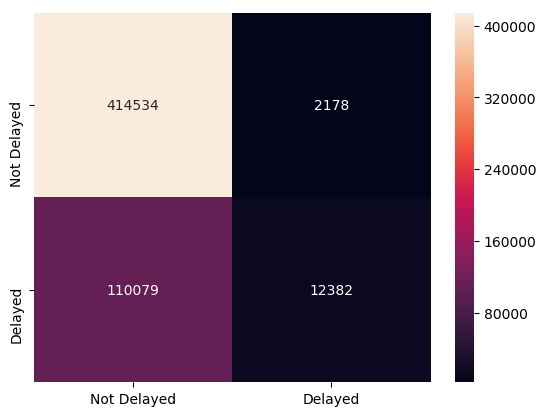

In [80]:
predictions = rf_gs.predict(X_test)

classes = ["Not Delayed", "Delayed"]
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=classes)
cm_df.index = classes

sns.heatmap(cm_df, annot=True, fmt='g');

In [81]:
tn, fp, fn, tp = cm.ravel()

precision   = tp / (tp+fp)
sensitivity = tp / (tp+fn)
accuracy    = (tp+tn) / (tp+fn+fp+tn)
specificity = tn / (tn+fp)

print('Precision  : ', precision)
print('Sensitivity: ', sensitivity)
print('Accuracy   : ', accuracy)
print('Specificity: ', specificity)

Precision  :  0.8504120879120879
Sensitivity:  0.10110974106041924
Accuracy   :  0.7917978088665419
Specificity:  0.9947733686574901


### pickle out the work

In [82]:
df1.to_pickle('./assets/final.pkl')